# PCA reconstruction metric

Want to create a metric involving PCA that allows us to clearly see which modes 
(and combinations of modes) are well-captured by the reconstruction process.

In [38]:
from pygdsm import GlobalSkyModel2016
import healpy as hp
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import seaborn as sns

import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM
import src.plotting as PL

RS = SH.RealSphericalHarmonics()

In [42]:
lmax=32
nside=16
npix = hp.nside2npix(nside)
# Generate the ylm matrix for later.
ylm_mat = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax)

# Generate foreground map.
fg_full_map = GlobalSkyModel2016(resolution='low').generate(60)

# Convert foreground map to real alm and Cl.
fg_alm = hp.map2alm(fg_full_map, lmax=lmax)
fg_alm = RS.complex2RealALM(fg_alm)

# Observe the Gaussian random field.
narrow_cosbeam = lambda x : BF.beam_cos(x, theta0=0.8)
mat_A_fm = FM.calc_observation_matrix_all_pix(nside=nside, lmax=lmax, Ntau=npix, Nt=npix, beam_use=narrow_cosbeam)
d = mat_A_fm @ fg_alm

# Add noise.
d_noisy, noise_covar = SM.add_noise(d, 1, Ntau=npix, t_int=1e4, seed=124)

3072 561
3072 561


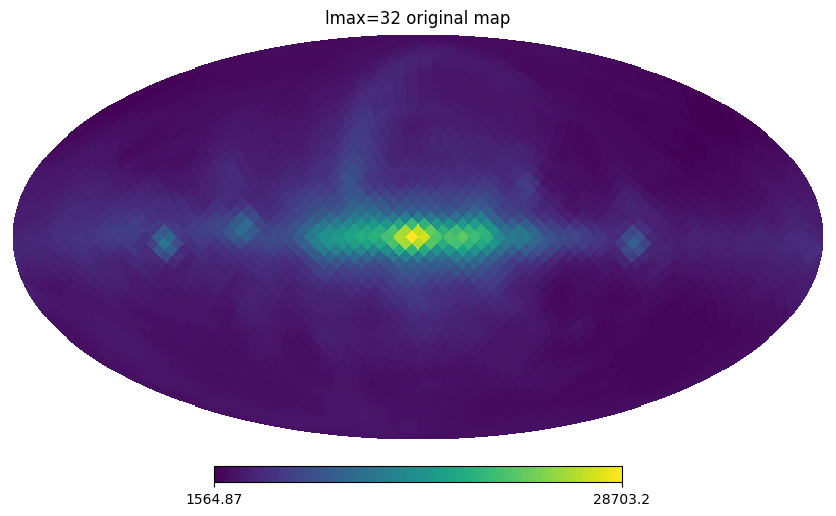

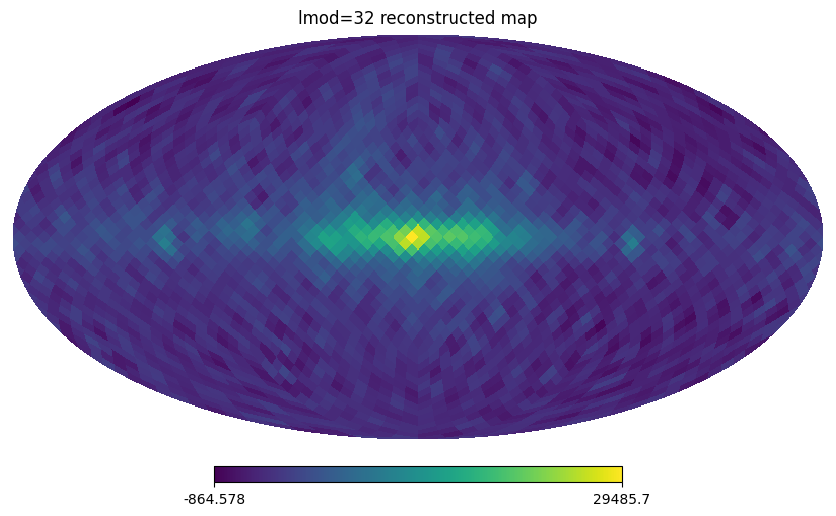

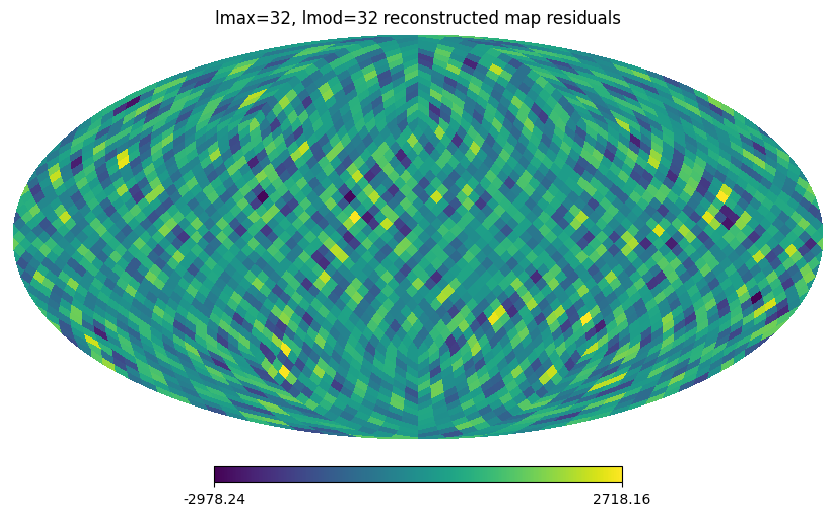

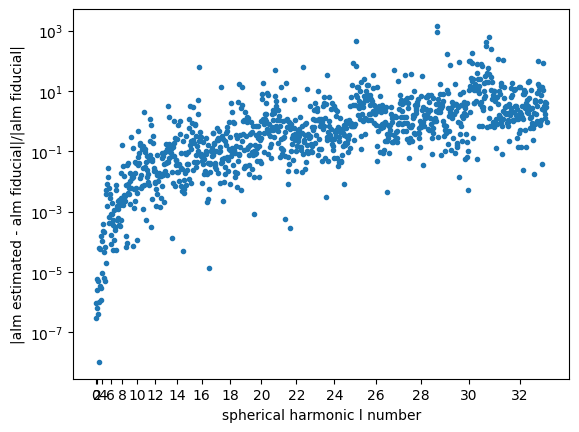

In [82]:
# First model the foreground map perfectly.
mat_W_perfect, cov_perfect = MM.calc_ml_estimator_matrix(mat_A=mat_A_fm, mat_N=noise_covar, cov=True)
a_ml_noisefree = mat_W_perfect @ d
a_ml_noisy = mat_W_perfect @ d_noisy

PL.compare_estimate_to_reality(a_reality=fg_alm, a_estimate=a_ml_noisy, ylm_mat=ylm_mat)

In [113]:
# Carry out SVD on the covariance matrix of the reconstructed alm. 
mat_U, arr_S, mat_Vh = svd(cov_perfect, full_matrices=False)

# Flip the arrays: we're interested in the lowest-variance components.
arr_S = np.flip(arr_S)
mat_Vh = np.flip(mat_Vh, axis=0)
mat_U = np.flip(mat_U, axis=1)

Text(0, 0.5, 'variance of basis vector')

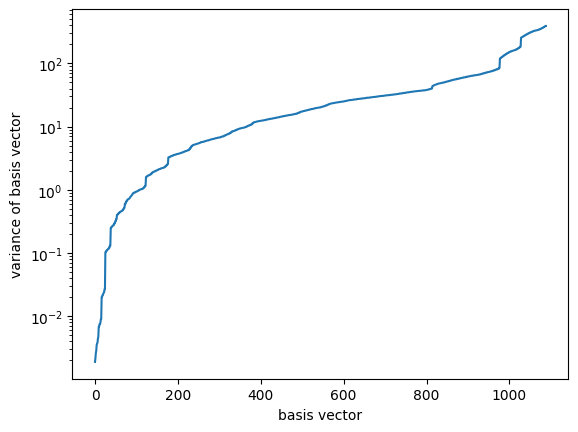

In [125]:
plt.semilogy(np.sqrt(arr_S))
plt.xlabel("basis vector")
plt.ylabel("variance of basis vector")

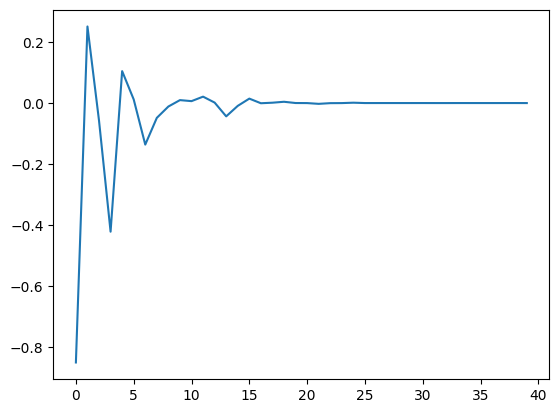

In [117]:
plt.plot(mat_Vh[0,:40])

Text(0.5, 23.52222222222222, 'alm index')

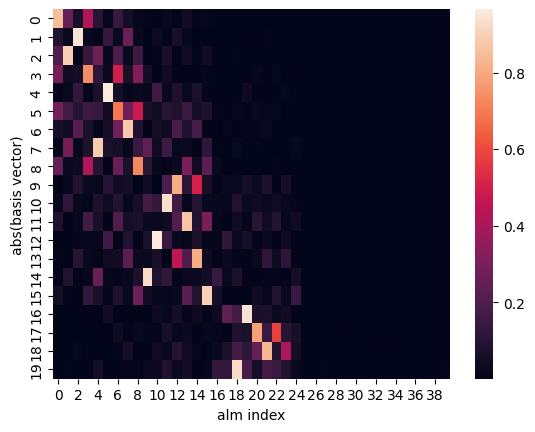

In [136]:
sns.heatmap(abs(mat_Vh[0:20,:40]))
plt.ylabel("abs(basis vector)")
plt.xlabel("alm index")

In [132]:
# Build a pipeline to take the SVD decomposition and make a truncated map.
def reconstruct_map_from_svd(a_ml, mat_Vh, truncation_idx):
    """
    For a given map estimate a_ml with the svd basis matrix mat_Vh, project the
    map estimate onto the 
    """
    a_trunc = np.zeros(len(a_ml))
    for i in range(truncation_idx):
        basis_vec = mat_Vh[i]
        a_trunc += np.dot(basis_vec, a_ml) * basis_vec
    return a_trunc

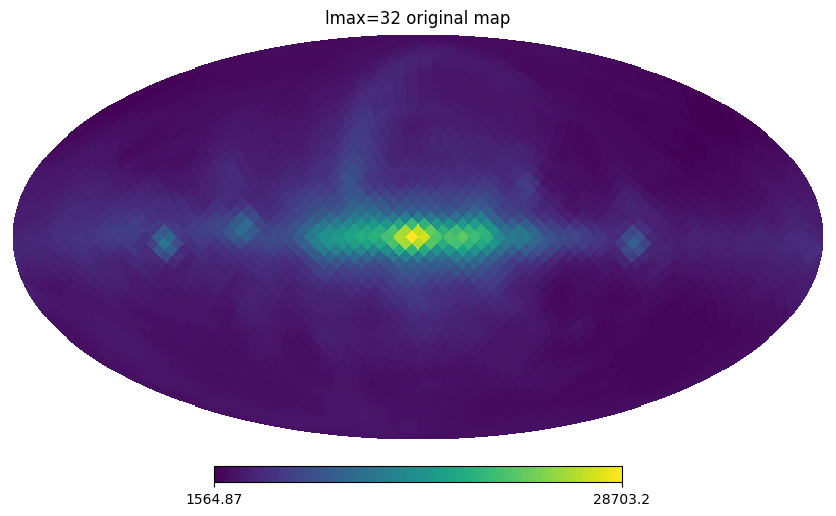

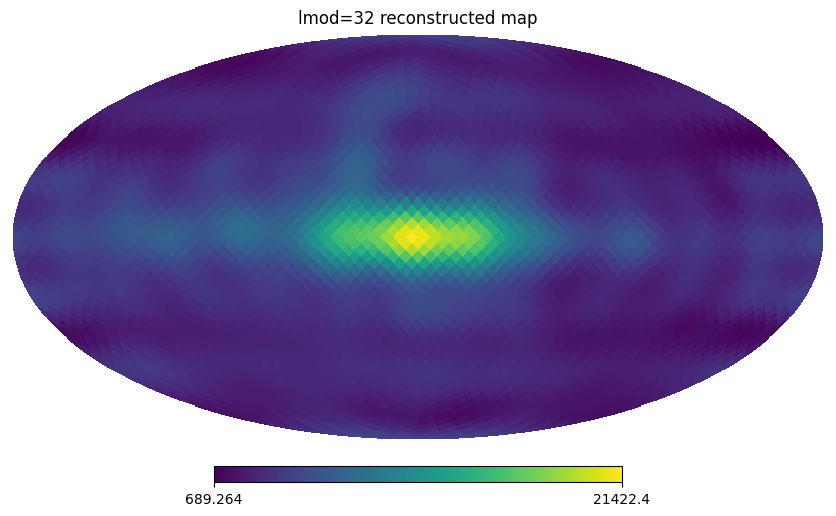

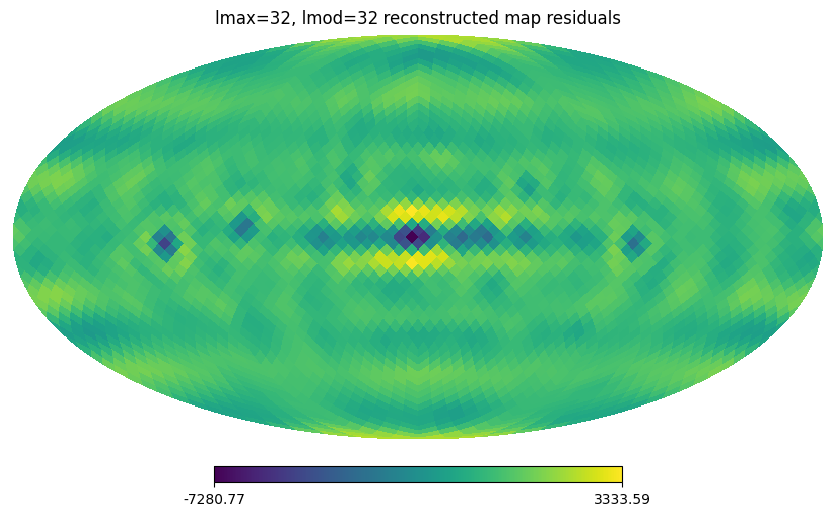

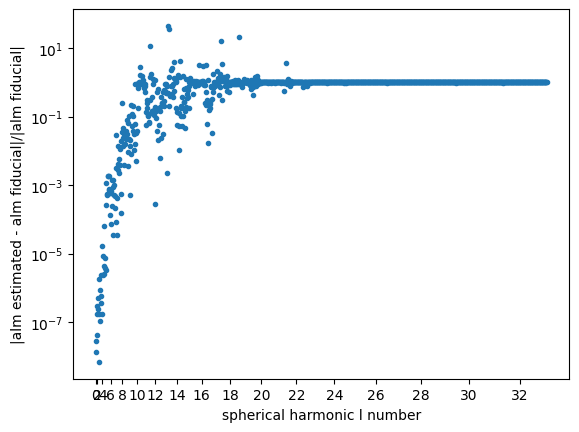

In [134]:
PL.compare_estimate_to_reality(a_reality=fg_alm, a_estimate=reconstruct_map_from_svd(a_ml_noisefree, mat_Vh, truncation_idx=200), ylm_mat=ylm_mat)

In [ ]:
# Presumably we can map the variation 